## Overview

The goal of this project is to predict the fare of an NYC taxi ride given some details about the trip. For this project, I used the 2017 data from the NYC Taxi Commission for both training and testing. Here is a link to the dataset: http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml

## Fetch Data

Let's start by importing a few packages and reading our data.

In [3]:
# Import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import seaborn as sns

# Read data
data = pd.read_csv('data/tripdata_2017.csv', parse_dates=[0, 1], index_col=0)

# Set styling to Seaborn's default
sns.set()

## Inspect Numerically
What does our data look like? Any missing values? Let's take a quick look.

In [4]:
# Inspect data
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 267132 entries, 2001-01-01 23:39:13 to 2017-12-31 23:56:35
Data columns (total 6 columns):
tpep_dropoff_datetime    267132 non-null datetime64[ns]
passenger_count          267132 non-null int64
trip_distance            267132 non-null float64
PULocationID             267132 non-null int64
DOLocationID             267132 non-null int64
fare_amount              267132 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 14.3 MB


In [5]:
# Inspect data
data.describe()

,passenger_count,trip_distance,PULocationID,DOLocationID,fare_amount
count,267132.000000,267132.000000,267132.000000,267132.000000,267132.000000
mean,1.621397,2.555020,163.144655,160.931641,11.774756
std,1.261890,3.100759,66.819716,70.387406,8.364122
min,0.000000,0.000000,1.000000,1.000000,-11.500000
25%,1.000000,0.970000,114.000000,107.000000,6.500000
50%,1.000000,1.600000,162.000000,162.000000,9.000000
75%,2.000000,2.890000,233.000000,233.000000,14.000000
max,6.000000,702.500000,265.000000,265.000000,174.000000


No apparent missing values, but there seems to be some invalid data points/outliers we have to deal with.

## Inspect Visually 

Before we make any changes, let's look at the distribution of all numeric values.

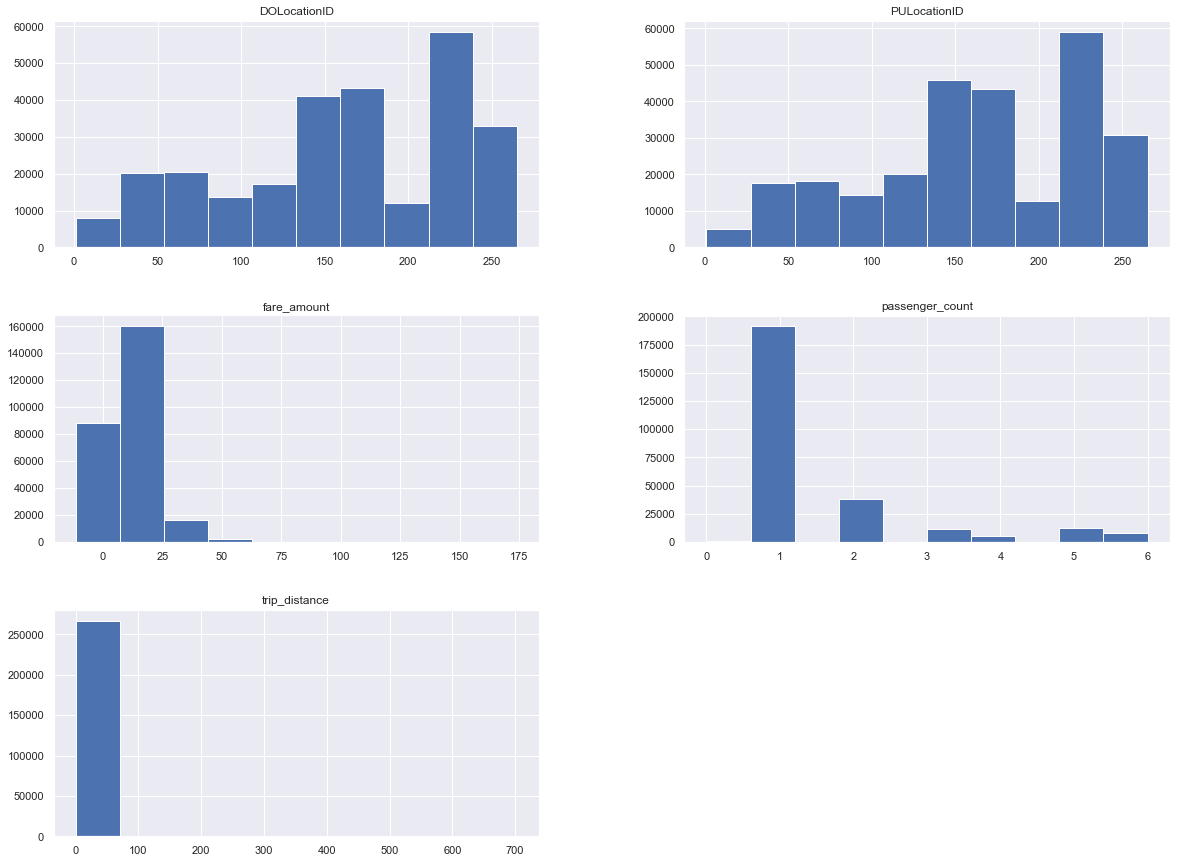

In [6]:
# Visualize distribution of numeric variables
data.hist(figsize=(20, 15))
plt.show()

## Initial Insights
1. Drop off Location and Pick up location won't be used in this prediction and will be removed from the dataset.
2. Fare amounts look reasonable. There are a few fare amounts which we have to inspect, but nothing outrageous. There are clearly some negative fares which we have to fix though.
3. Passenger counts range from 0 to 6. A passenger count of 0 seems unreasonable. The NYC Taxi Commission reported that passenger count does not influence fare amount, so this column will be dropped anyhow.
4. For trip distances, there is at least one outlier which we'll have to remove. We'll have to inspect shorter distances too.
5. We need to add a column for trip duration as that is obviously critical.

## Initial Cleaning
### Pickup / Droppoff Location IDs / Passenger Count
Let's begin by dropping the **Pickup and Dropoff Location IDs**, as well as the **Passenger Counts**, as we won't need them for this prediction.

In [7]:
# Drop unnecessary columns
data.drop(['PULocationID', 'DOLocationID', 'passenger_count'], inplace=True, axis=1)

### Trip Distances
For this project, we want to work with realistic trip distances. While it's perfectly fine to have a trip distance of 0.02 miles or 200 miles, these do not represent average trip lengths. Furthermore, predicting a fare amount for a trip lasting 0.02 miles is useless anyway. Thus, I have chosen logical thresholds here:

$$min\ distance = 0.2\ miles$$
$$max\ distance = 60\ miles$$

In [8]:
# Remove trips < 0.2 miles or > 60 miles
print('Dataset size before cleaning trip distances: ', len(data))
data = data[(data.trip_distance >= 0.2) & (data.trip_distance <= 60)]
print('Dataset size after: ', len(data))

Dataset size before cleaning trip distances:  267132
Dataset size after:  265082


Let's visualize the distribution of our data quickly.

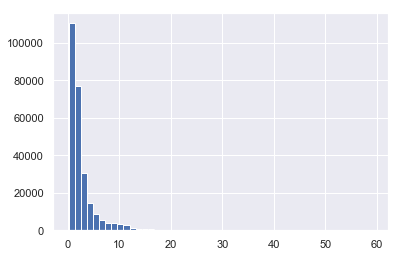

In [9]:
# PDF of trip distances
data.trip_distance.hist(bins=50)
plt.show()

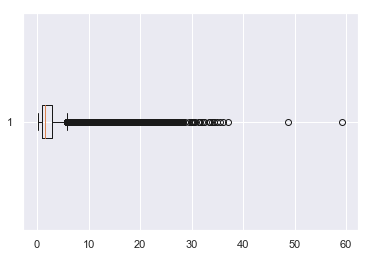

In [10]:
# Boxplot of trip distances
plt.boxplot(data.trip_distance, vert=False)
plt.show()

Our data is skewed to the right, but that's ok since it's perfectly fine to have a trip duration of 30 miles or 50 miles. We want our model to work for such trips too! We can see that most of our data is in the 0 - 10 mile range though.

### Trip Durations

Our initial data inlcudes start and end times/dates, but it doesn't include a field for trip duration.

Let's start by creating this field:

In [11]:
# Create new field: trip duration (stored as seconds)
data['trip_duration'] = (data.tpep_dropoff_datetime - data.index) \
                            .transform(lambda x: x.total_seconds())

Again, we want to think logically here. Does it make sense to predict the fare of a journey that lasted 10 seconds? Probably not. We want to be realistic while allowing for some extreme, yet plausible cases.

Here are the thresholds I've chosen:
$$min\ duration = 2\ minutes$$
$$max\ duration = 2\ hours$$

In [12]:
# Remove trips < 120 seconds or > 7200 seconds
print('Dataset size before cleaning trip durations: ', len(data))
data = data[(data.trip_duration >= 120) & (data.trip_duration <= 7200)]
print('Dataset size after: ', len(data))

Dataset size before cleaning trip durations:  265082
Dataset size after:  261208


Again, let's visualize our data.

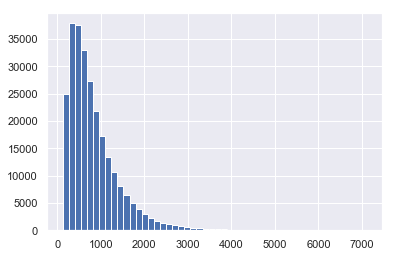

In [13]:
# Plot distribution of trip duration.
data.trip_duration.hist(bins=50)
plt.show()

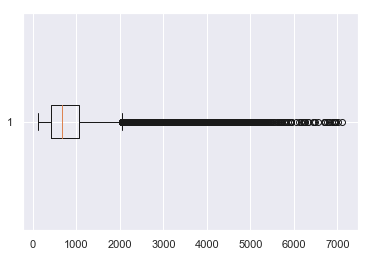

In [14]:
# Boxplot of trip distances
plt.boxplot(data.trip_duration, vert=False)
plt.show()

Same as before, our data is skewed to the right, but that is perfectly fine.
### Fare Amount 
We saw previously that we had some negative fare amounts. There were also some potential outliers that we had to inspect.

Let's begin by looking at a boxplot of fare amounts:

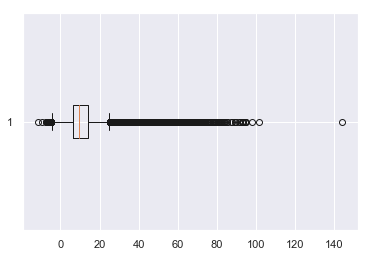

In [15]:
# Boxplot of fare amounts
plt.boxplot(data.fare_amount, vert=False)
plt.show()

To begin with, let's inspect the outlier on the right:

In [16]:
# Inspect outlier
data[data.fare_amount > 125]

,tpep_dropoff_datetime,trip_distance,fare_amount,trip_duration
tpep_pickup_datetime,,,,
2017-10-16 19:51:30,2017-10-16 21:42:59,48.74,144.5,6689.0


Seems perfectly reasonable, so we'll leave it alone.

What about the negative values? It's possible we can just invert them to make them positive.

In [17]:
# Inspect negative fare amounts to see if we can invert them
data[data.fare_amount < 0].describe()

,trip_distance,fare_amount,trip_duration
count,50.000000,50.000000,50.000000
mean,0.616600,-5.300000,456.720000
std,0.199209,1.484615,949.878532
min,0.230000,-11.500000,121.000000
25%,0.462500,-5.875000,203.250000
50%,0.655000,-5.000000,293.500000
75%,0.782500,-4.500000,389.750000
max,0.990000,-3.500000,6916.000000


From above, we can see that the fare amounts seem reasonable if we simply invert their signs. So instead of dropping them, let's just invert their signs.

In [18]:
# Invert negative fare durations
data.fare_amount = data.fare_amount.abs()

According to the NYC Taxi Commission, the initial starting price is $\$$2.50 dollars and the minimum price per 0.2 miles (which is our lower bound for distance) is $\$$0.50. Thus, it makes sense both logically and quantitavely to place a lower limit of $\$$3.00.

$$min\ fare\ amount = $3.00$$

There are only seven instances below this threshold, so we'll just remove them.

In [19]:
# Count trips with fare < $3.00
len(data[data.fare_amount < 3])

7

In [20]:
# Remove trips with fare < $3.00
print('Dataset size before cleaning Fare Amounts: ', len(data))
data = data[data.fare_amount >= 3]
print('Dataset size after: ', len(data))

Dataset size before cleaning Fare Amounts:  261208
Dataset size after:  261201


As usual, let's end this section by visualizing our data. Looks great!

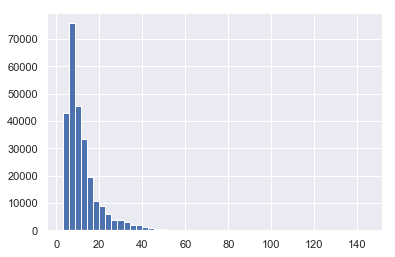

In [21]:
# PDF of fare amounts
data.fare_amount.hist(bins=50)
plt.show()

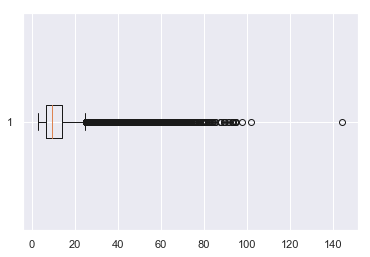

In [22]:
# Boxplot of fare amount
plt.boxplot(data.fare_amount, vert=False)
plt.show()

## Comparing Dependent Columns
So far, we've treated each column individually. Now we have to consider the cases when two quantitatve relationships don't make sense relative to each other. Namely, we need to look at:
1. Distance vs Duration (avg speed)
2. Distance vs Fare Amount (fare per mile)
2. Duration vs Fare Amount (fare per hour)

To address these issues, let's create three temporary columns and view their distributions:
### 1. Avg Speed

In [23]:
# Calculate avg speed (mph). Multiply by 3600 (seconds to hours)
data['avg_speed'] = round((3600 * data.trip_distance) / data.trip_duration, 2)

Logically thinking, we might assume that avg speeds may range between ~2 and ~70 miles per hour.

These avg speeds are generous, since at 2 mph, you can probably walk faster. Whereas at 70 mph, your driver is speeding most of the journey and is probably driving dangerously.

Let's inspect our data, and see what it tells us.

In [24]:
# Numerically inspect avg_speeds
data.avg_speed.describe()

count    261201.000000
mean         10.917419
std           5.498278
min           0.380000
25%           7.260000
50%           9.770000
75%          13.140000
max         254.780000
Name: avg_speed, dtype: float64

In [25]:
# Get 0.25 and 99.75 percentils of avg soeeds
np.percentile(data.avg_speed, [0.25, 50, 99.75])

array([ 2.17,  9.77, 36.82])

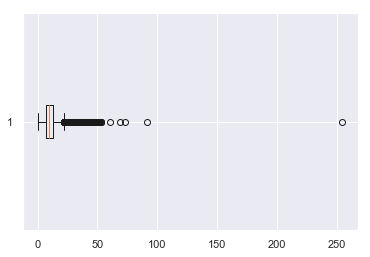

In [26]:
# Visually inspect avg_speeds
plt.boxplot(data.avg_speed, vert=False)
plt.show()

We can see that our data is highly skewed to the right. The percentile command showed us that 99.5% of avg speeds lie between 2.17 and 36.82 mph, but we won't just take them on face value. To help us decide on the thresholds, let's look at a subset of our data. Let's begin by looking at the distribution of trips with avg speeds from 0 to 10 mph.

Notice how 2 mph seems like a suitable (and realistic) cut off point. After that, the frequency of trips sharply goes up.

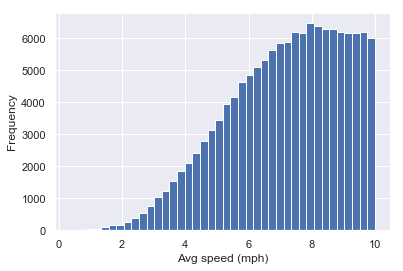

In [27]:
# Frequency distribution of avg_speeds limited to avg speed of 10 mph.
data[data.avg_speed < 10].avg_speed.hist(bins=40)
plt.xlabel('Avg speed (mph)')
plt.ylabel('Frequency')
plt.show()

Let's do the same for the other end, this time, limiting rides to 70 mph which is our hypothetical upper limit.

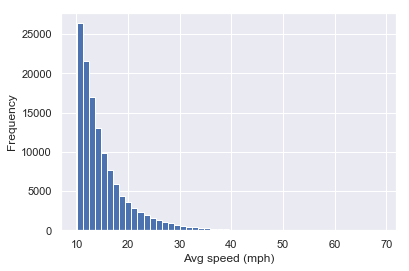

In [28]:
# Frequency distribution of avg_speeds [10 mph to 70 mph]
data[(data.avg_speed > 10) & (data.avg_speed <= 70)].avg_speed.hist(bins=50)
plt.xlabel('Avg speed (mph)')
plt.ylabel('Frequency')
plt.show()

Although 35 looks like the furthest point for which we see data, we want to incorporate some logic/reason to our decision. It seems perfectly fine to have a higher avg speed especially if the duration is long and most of the journey is on the highway.

Thus, we'll place 60 mph as our upper cutoff point, which again, is quantitavely and logically plausible.

In [29]:
# Remove trips with avg speeds < 2 mph or > 60 mph
print('Dataset size before cleaning Avg Speed: ', len(data))
data = data[(data.avg_speed >= 2) & (data.avg_speed <= 60)]
print('Dataset size after: ', len(data))

Dataset size before cleaning Avg Speed:  261201
Dataset size after:  260716


Let's look at a scatter plot of distance vs duration.

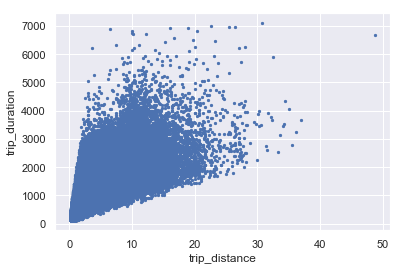

In [30]:
# Scatter plot of distance vs duration
data.plot(kind='scatter', x='trip_distance', y='trip_duration', marker='.')
plt.show()

Finally, let's look at a box plot of the avg speeds one last time. Looking better.

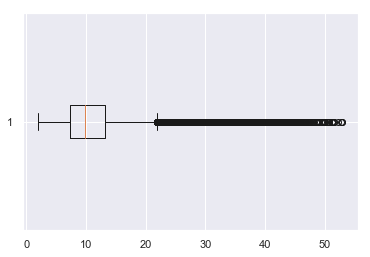

In [31]:
# Boxplot of avg_speeds
plt.boxplot(data.avg_speed, vert=False)
plt.show()

### 2-3. Fare Per Mile and Fare Per Hour

While we'd like to do a similar procedure for $fare\ per\ mile$ and $fare\ per\ hour$, it is not so simple.

According to the NYC taxi rates, the taxi fare can be estimated by:

$$Fare =  $2.50 + ($2.50 * miles\ driven)\ OR\ ($0.50 * minutes\ driven\ (in\ slow\ traffic)\ )$$

Thus, a car may sit idle for 5 minutes and the passenger will be charged $\$$2.50 even while not moving. To deal with this issue, we'll just use percentile values to calculate and remove extreme cases from both $fare\ per\ mile$ and $fare\ per\ hour$.

In [32]:
# Calculate fare per mile. Subtract 2.5 as starting price.
data['fare_per_mile'] = round((data.fare_amount - 2.5) / data.trip_distance, 2)

# Calculate fare per hour. Multiply by 3600 (seconds to hours).
# Subtract 2.5 as starting price.
data['fare_per_hour'] = round((3600 * (data.fare_amount - 2.5)) / data.trip_duration, 2)

In [33]:
# Calculate 0.25 and 99.75 percentiles for fare per mile
np.percentile(data.fare_per_mile, [0.25, 50, 99.75])

array([ 2.22    ,  3.75    , 11.692125])

In [34]:
# Calculate 0.25 and 99.75 percentiles for fare per hour
np.percentile(data.fare_per_hour, [0.25, 50, 99.75])

array([24.      , 36.44    , 94.492125])

In [35]:
# Remove extreme cases for fare/mile and fare/hour
print('Dataset size before cleaning fare/mile and fare/hour: ', len(data))
data = data[(data.fare_per_mile >= 2.22) & (data.fare_per_mile <= 11.7) &
            (data.fare_per_hour >= 24) & (data.fare_per_hour <= 94.5)]
print('Dataset size after: ', len(data))

Dataset size before cleaning fare/mile and fare/hour:  260716
Dataset size after:  258173


Finally, let's look at a scatter plot between distance and fare, and then between duration and fare. Looks great.

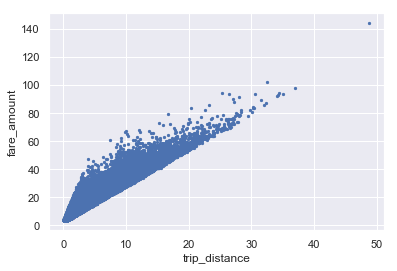

In [36]:
# Scatter plot of distancs vs fare
data.plot(kind='scatter', x='trip_distance', y='fare_amount', marker='.')
plt.show()

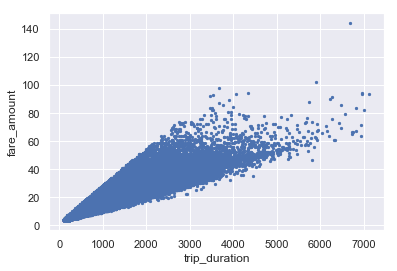

In [37]:
# Scatter plot of duration vs fare
data.plot(kind='scatter', x='trip_duration', y='fare_amount', marker='.')
plt.show()

Before we end this section, again, let's visualize the distribution of our numeric variables. Looks much better this time! Certain ML algorithms require our data to be normally distributed, so it's good to understand the distribution of our data.

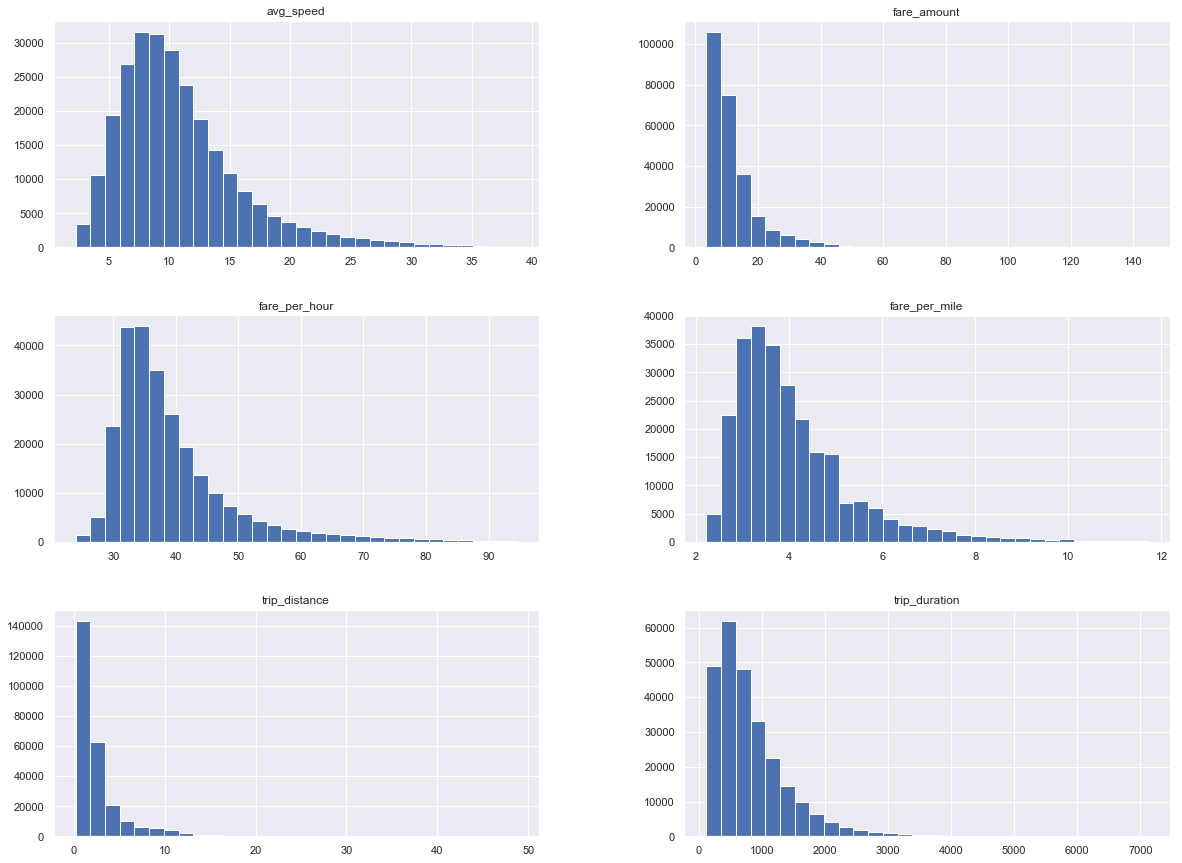

In [38]:
# Plot PDF of numeric variables
data.hist(figsize=(20, 15), bins=30)
plt.show()

## Preparing Our Data For ML Algorithms
### Create New Features
ML algorithms require our data to be in numeric format. Currently, we have a datetime index for the start and end of our trips. Our model cannot use these, so instead, we'll just extract two features:
1. Weekday or Weekend (categorical)
2. Hour of day  (numerical)

In [39]:
# 1 = weekday, 0 = weekend. 7 days of week.
weekday = {0:1, 1:1, 2:1, 3:1, 4:1, 5:0, 6:0}

# Create new feature: day of week. Store as type category
data['weekday'] = data.index.weekday.map(weekday).astype('category')

In [40]:
# Create new feature: hour of day
data['hour'] = data.index.hour

### Convert Hour into a Cyclical Feature

The hour of day is a cyclical variable. As we have it, 1 is close to 2, and 2 is close to 3, etc. However, our current format neglects the fact that 23 is also close to 0 (because $hour$ is a cyclical variable).

Let's create a better representation of the hour by mapping each hour to a x and y component on a unit circle. We know there are 2π radians in a circle and 24 hours in a day. Thus, we can get the x and y components of the hour as following:

$$hour\ cos = cos( hour * (2π / 24))$$
$$hour\ sin = sin( hour * (2π / 24))$$

In [41]:
# Calculate hour_cos and hour_sin
data['hour_cos'] = np.cos(data.hour*(2.*np.pi/24))
data['hour_sin'] = np.sin(data.hour*(2.*np.pi/24))

Later, we can test our model on both representations of $hour$.

### Check Our Data For Multilinearity

Colinearity or multilinearity will inflate our variance, and thus, reduce the effectiveness of our model. Thus, we want our predictor variables to be linearly independent. To inspect for multilinearity, we will compute the Variance Inflation Factor (VIF) for each of our predictor variables.

Our threshold for VIF will be 5. That is, a VIF > 5 indicates linear dependence which we would need to address.

To begin, let's create a subset of our dataframe that only contains numeric values, while also disregarding any fare calculations.

In [42]:
# Import VIF function
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Drop datetime index and get numeric columns
numeric = data.reset_index()._get_numeric_data()
# Drop any fare calculations and columns
numeric.drop(['fare_per_hour', 'fare_per_mile', 'fare_amount'], axis=1, inplace=True)

# Print selected columns
print('Columns :', numeric.columns.values)

Columns : ['trip_distance' 'trip_duration' 'avg_speed' 'hour' 'hour_cos' 'hour_sin']


We will start by inlcuding all features and seeing the VIF scores we get.

Let's define a small helper function below that will allow us to visualize the VIF scores nicely.

In [43]:
# Helper function for computing and displaying VIF scores.
def get_vif(data) :
    vif = pd.DataFrame()
    vif["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    vif["Feature"] = data.columns
    return vif

In [44]:
# Calculate VIF scores
get_vif(numeric)

,VIF,Feature
0,9.968168,trip_distance
1,9.160437,trip_duration
2,8.291084,avg_speed
3,9.288919,hour
4,1.144650,hour_cos
5,2.408603,hour_sin


Ouch! It seems like we have some issues here. Four of our features are beyond the threshold. We need to remove some features.

Which ones? Well, logically thinking, the most important features are distance, duration, and of our hour versions. 

Let's begin comparing our VIF when we remove $hour$ vs when when remove $hour\ sin$ and $hour\ cos$.

In [45]:
# Compute VIFs after removing hour
get_vif(numeric.drop('hour', axis=1))

,VIF,Feature
0,6.481661,trip_distance
1,5.619364,trip_duration
2,3.054608,avg_speed
3,1.140303,hour_cos
4,1.157345,hour_sin


In [46]:
# Compute VIFs after removing hour_sin and hour_cos
get_vif(numeric.drop(['hour_sin', 'hour_cos'], axis=1))

,VIF,Feature
0,8.522162,trip_distance
1,7.644618,trip_duration
2,5.788605,avg_speed
3,4.403576,hour


As you can see, we get better (lower) VIFs for all features when we remove $hour$. That makes sense because we can imagine our circular representation of $hour\ sin$ and $hour\ cos$ as inducing some 'randomness', and thus, decreasing linearity.

We still need  lower VIF scores though, as two of them still exceed our threshold.

This time, we'll also remove $avg\ speed$ which isn't a useful predictor anyway.

In [47]:
get_vif(numeric.drop(['hour', 'avg_speed'], axis=1))

,VIF,Feature
0,5.112218,trip_distance
1,5.542898,trip_duration
2,1.136766,hour_cos
3,1.153591,hour_sin


Again, we can see better VIF scores, but we still have distance and duration with high VIF scores. But we don't really want to delete them...

Recall from our previous visualizations, that distance and duration were highly skewed to the right.

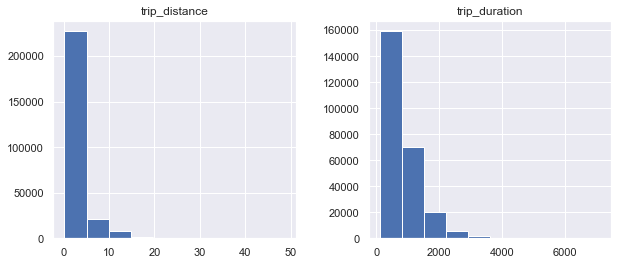

In [48]:
# Visualize distributions of distance and duration
numeric[['trip_duration', 'trip_distance']].hist(figsize=(10, 4))
plt.show()

Let's take the log of these features. Many ML algorithms requre our data to be normally distributed, so this transformation can potentially hit two birds with one stone. Let's see how the log function transforms our distribution and VIF scores.

Note we don't need to take the log of $hour\ sin$ and $hour\ cos$ as well. We can't anyway because the log fucntion isn't defined for negative values.

Here is the new distribution for trip $distance$ and $duration$:

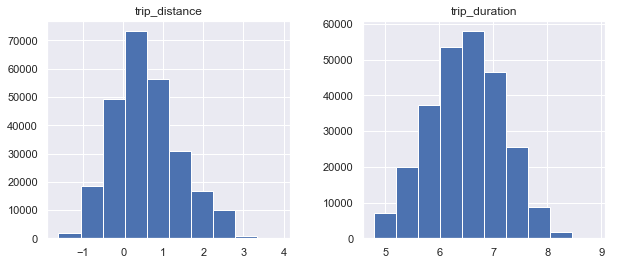

In [49]:
# Visualize distributions of distance and duration after taking log
np.log(numeric[['trip_duration', 'trip_distance']]).hist(figsize=(10, 4))
plt.show()

In [50]:
# Select duration and distance columns and take log
log_distance_duration = np.log(numeric[['trip_duration', 'trip_distance']])
# Select hour_sin and hour_cos columns
hour = numeric[['hour_sin', 'hour_cos']]

# Concatenate all columns into one dataframe
log_numeric = pd.concat( [log_distance_duration , hour], axis=1 )

# Compute VIF scores
get_vif(log_numeric)

,VIF,Feature
0,2.000753,trip_duration
1,1.782057,trip_distance
2,1.153582,hour_sin
3,1.092506,hour_cos


Wow! A significant difference. Our data looks much better and our VIF scores are much better.

In case you're curious, here is what we get if we use the other version of $hour$. Not nearly as good.

In [51]:
# Repeat steps above, but on numeric version of hour
hour2 = numeric[['hour']]
log_numeric2 = pd.concat( [log_distance_duration , hour2], axis=1 )
get_vif(log_numeric2)

,VIF,Feature
0,7.332210,trip_duration
1,1.805062,trip_distance
2,5.837574,hour


### Encode Categorical Data

Some final steps. Here is what we need to do:
1. Combine our scaled down data (with optimal VIF scores) with $fare\ amount$ and any categorical data.
2. Encode categorical variables into numeric types

Here is what our data currenltly looks like:

In [52]:
# Look at our columns
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 258173 entries, 2008-12-31 17:48:27 to 2017-12-31 23:48:11
Data columns (total 11 columns):
tpep_dropoff_datetime    258173 non-null datetime64[ns]
trip_distance            258173 non-null float64
fare_amount              258173 non-null float64
trip_duration            258173 non-null float64
avg_speed                258173 non-null float64
fare_per_mile            258173 non-null float64
fare_per_hour            258173 non-null float64
weekday                  258173 non-null category
hour                     258173 non-null int64
hour_cos                 258173 non-null float64
hour_sin                 258173 non-null float64
dtypes: category(1), datetime64[ns](1), float64(8), int64(1)
memory usage: 21.9 MB


In [53]:
# Select only fare amount and weekday columns
data = data.reset_index()[['fare_amount', 'weekday']]
# Concat with our cleaned scaled data from above.
data = pd.concat([data, log_numeric], axis=1)

# Encode categorical data (weekday)
data = pd.get_dummies(data, drop_first=True)
# Rename column as weekday instead of weekday_1
data.rename(columns={'weekday_1': 'weekday'}, inplace=True)

Let's visualize the distribution of our numeric data one last time...

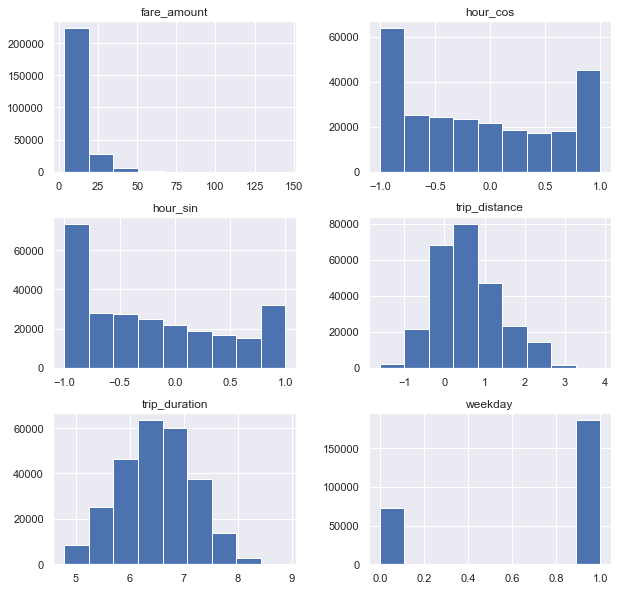

In [54]:
# Plot PDFs of numeric features
data.hist(figsize=(10, 10), bins=9)
plt.show()

## Out-of-the-box Machine Learning Algorithms
At this stage, our data is ready and we can begin exploring some machine learning algorithms. We'll start by using out-of-the-box models, and then we'll go about fine tuning them after we've selected one or two models we want to explore.

First, we'll split our data into training and testing tests.

We'll also import `mean_squared_error()` since we'll be using it as a measure for model performance.



In [77]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# Split data into training and testing sets
X, y = data.drop('fare_amount', axis=1), data.fare_amount
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

 Since this is a regression problem, my intuition will be to use:
1. Simple Linear Regression
2. Random Forests
3. XGBoost

For each model, we will 
1. Cross-validate on the training set.
2. Test on the testing set 

We do this to check if the model is overfitting our data. Remember that at this stage, we are performing out of the box evaluations to get a sense for which algorithms we want select and fine tune later on.

### Linear Regression

In [224]:
from sklearn.linear_model import LinearRegression

# Create model and fit data
lin = LinearRegression()
lin.fit(X_train, y_train)

# Predict and calculate RMSE on test data
y_pred = lin.predict(X_test)
print('Untuned Linear Regression RMSE (test data):',
          np.sqrt(mean_squared_error(y_test, y_pred)))

# Perform 5 fold cross validation using same model
scores = cross_val_score(lin, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
lin_rmse_scores = np.sqrt(-scores)

# Display results
print('Mean 5-fold CV (training data):', lin_rmse_scores.mean())
print('Standard deviation', lin_rmse_scores.std())

Untuned Linear Regression RMSE (test data): 3.5900429679148673
Mean 5-fold CV (training data): 3.6053310911106586
Standard deviation 0.05210926124586425


On a thoroughly cleaned dataset, we see that an out-of-the-box Linear Regression model provides an RMSE of ~$\$$3.60. Given that the median fare is $\$$9.00 (because most trips are short), we would like to see a better prediction. At least we see the model ins't overfitting our data.

### Random Forest

In [226]:
from sklearn.ensemble import RandomForestRegressor

# Create model and fit data
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

# Predict and calculate RMSE on test data
y_pred = rf.predict(X_test)
print('Untuned Random Forest RMSE (test data):',
          np.sqrt(mean_squared_error(y_test, y_pred)))

# Perform 5 fold cross validation using same model
scores = cross_val_score(rf, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
rf_rmse_scores = np.sqrt(-scores)

# Display results
print('Mean 5-fold CV (training data):', rf_rmse_scores.mean())
print('Standard deviation', rf_rmse_scores.std())

Untuned Random Forest RMSE (test data): 0.49690705286848436
Mean 5-fold CV (training data): 0.5043665578808395
Standard deviation 0.025537834242805996


Impressive! Our Random Forest Implementation sliced our RMSE by a factor of 7. It's now ~$\$$0.50 which is much better and actually quite good. Again, it is not overfitting our data!

### XGBoost

In [228]:
import xgboost as xgb

# Create model and fit data
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)

# Predict and calculate RMSE on test data
y_pred = xgb_reg.predict(X_test)
print('Untuned XGBoost Regressor RMSE (test data):',
          np.sqrt(mean_squared_error(y_test, y_pred)))

# Perform 5 fold cross validation using same model
scores = cross_val_score(rf, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
xgb_reg_rmse_scores = np.sqrt(-scores)

# Display results
print('Mean 5-fold CV (test data):', xgb_reg_rmse_scores.mean())
print('Standard deviation', xgb_reg_rmse_scores.std())

Untuned XGBoost Regressor RMSE (test data): 0.5163210495322434
Mean 5-fold CV (test data): 0.5034685649982713
Standard deviation 0.026285607545094923


Wow! An out of the box XGBoost algorithm produces a similar result to Random Forests. Let's continue our journey forwards.

## Fine Tuning Our Models
Given these results, it seems pretty obvious that we'll want to tune the last two models: Random Forests and XGBoost. The goal of course is to see which of them can provide the best (lowest) RMSE score without overfitting our data.

Since we are using a Decision Tree as the base class/learner for both models, we will limit $n\_estimators$ to 200 for all XGBoost predictions and 400 for all Random Forest calculations. For both algorithms, we begin by using Random Search and move on to Grid Search (for hyperparameter tuning).

Results will be summarized at the end of each section.

### Random Forest

**Random Search 1**

In [206]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [210]:
# Define random grid parameters
random_grid = {'n_estimators': [400],
           'max_features': [2, 3],
           'max_depth': [40, 60, 80, 100],
           'min_samples_split': [5, 10, 15, 20],
           'min_samples_leaf': [2, 5, 10, 15]}

# Random search of parameters using 3 fold cross validation.
# Search 50 combinations, and use all available cores
rf_random_grid = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                                    scoring='neg_mean_squared_error', n_iter=50, cv=3,
                                     n_jobs=-1, random_state=42)

# Fit our data
rf_random_grid.fit(X_train, y_train);

In [212]:
# Display best params + RMSE
print("Best parameters found: ", rf_random_grid.best_params_)
print("Lowest RMSE found using 400 estimators: ", np.sqrt(np.abs(rf_random_grid.best_score_)))

Best parameters found:  {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 3, 'max_depth': 100}
Lowest RMSE found using 400 estimators:  0.4797140774652929


**Grid Search 1**

In [219]:
# Define random grid parameters
cv_grid = {'n_estimators': [400],
               'max_features': [3],
               'max_depth': [80, 90, 100, 110],
               'min_samples_split': [6, 8, 10, 12],
               'min_samples_leaf': [2, 4, 6, 8]}

# Grid search of parameters using 3 fold cross validation.
# Search all 64 different combinations, and use all available cores
rf_grid = GridSearchCV(estimator = rf, param_grid = cv_grid, cv = 3,
                       scoring='neg_mean_squared_error', n_jobs = -1)

# Fit our data
rf_grid.fit(X_train, y_train);

In [220]:
# Display best params + RMSE
print("Best parameters found: ", rf_grid.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(rf_grid.best_score_)))

Best parameters found:  {'max_depth': 110, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 400}
Lowest RMSE found:  0.47851484013365814


**Grid Search 2**

In [221]:
# Define random grid parameters
cv_grid = {'n_estimators': [400],
               'max_features': [3],
               'max_depth': [90, 100, 110],
               'min_samples_split': [7, 8, 9],
               'min_samples_leaf': [2, 3, 4]}

# Grid search of parameters using 3 fold cross validation.
# Search all 64 different combinations, and use all available cores
rf_grid = GridSearchCV(estimator = rf, param_grid = cv_grid, cv = 3,
                       scoring='neg_mean_squared_error', n_jobs = -1)

# Fit our data
rf_grid.fit(X_train, y_train);

In [230]:
# Save best RF estimator
best_rf_model = rf_grid.best_estimator_

# Display best params + RMSE
print("Best parameters found: ", rf_grid.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(rf_grid.best_score_)))

Best parameters found:  {'max_depth': 110, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 400}
Lowest RMSE found:  0.47811218035965286


As you can see, by tuning our Random Forest, we managed to get a 5-6% decrease from our original out-of-the-box RMSE score. It is unlikely to get a score that is significantly better. Now, let's test our best RF model on our test data. An RMSE of ~$\$$0.46. Great!

In [231]:
y_pred = best_rf_model.predict(X_test)
print('Tuned Random Forest RMSE (test data):',
          np.sqrt(mean_squared_error(y_test, y_pred)))

Tuned Random Forest RMSE (test data): 0.46043237632343353


### XGBoost

Again, we need to test our model with different hyperparamter values to see how much we can optimize our RMSE score. We'll begin with RandomSearch and move on to Grid Search. Again, a summary will be given at the end.

**Random Search 1**

In [179]:
# Create an initial set of hyperparametrs to test
random_grid = {'learning_rate': [0.001, 0.01, 0.1],
               'max_depth': [5, 10, 15],
               'colsample_bytree': [0.2, 0.3, 0.4],
               'objective': ['reg:linear'],
               'subsample': [0.2, 0.3, 0.4],
               'n_estimators': [200]}

# Initialize a random search with 25 iterations, 3-fold cross validation
xgb_random_grid = RandomizedSearchCV(estimator=xgb_reg, param_distributions=random_grid,
                                    scoring='neg_mean_squared_error', n_iter=25, cv=3,
                                     n_jobs=-1, random_state=42)

# Fit randomsearch on data
xgb_random_grid.fit(X_train, y_train);

# Display best params + RMSE
print("Best parameters found: ", xgb_random_grid.best_params_)
print("Lowest RMSE found with 200 estimators: ", np.sqrt(np.abs(xgb_random_grid.best_score_))) 

Best parameters found:  {'subsample': 0.3, 'objective': 'reg:linear', 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.4}
Lowest RMSE found with 200 estimators:  0.481280700144203


**Grid Search 1**

In [189]:
# Create an initial set of hyperparametrs to test
cv_grid = {'learning_rate': [ 0.05, 0.1, 0.2],
               'max_depth': [5, 8, 10],
               'colsample_bytree': [0.2, 0.4, 0.6],
               'objective': ['reg:linear'],
               'subsample': [0.2, 0.4, 0.6],
               'n_estimators': [200]}

# Initialize Grid Search with 81 iterations, 3-fold cross validation. 200 Estimators
xgb_grid = GridSearchCV(estimator = xgb_reg, param_grid = cv_grid, cv = 3, n_jobs = -1,
                       scoring='neg_mean_squared_error')

# Fit Grid Search on data
xgb_grid.fit(X_train, y_train);

# Display best params + RMSE
print("Best parameters found: ", xgb_grid.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(xgb_grid.best_score_)))

Best parameters found:  {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200, 'objective': 'reg:linear', 'subsample': 0.6}
Lowest RMSE found:  0.4625378003718493


**Grid Search 2**

In [190]:
# Create an initial set of hyperparametrs to test
cv_grid = {'learning_rate': [ 0.05, 0.075, 0.1],
               'max_depth': [7, 8, 9],
               'colsample_bytree': [0.5, 0.6, 0.7],
               'objective': ['reg:linear'],
               'subsample': [0.5, 0.6, 0.7],
               'n_estimators': [200]}

# Initialize Grid Search with 81 iterations, 3-fold cross validation. 200 Estimators
xgb_grid = GridSearchCV(estimator = xgb_reg, param_grid = cv_grid, cv = 3, n_jobs = -1,
                       scoring='neg_mean_squared_error')

# Fit Grid Search on data
xgb_grid.fit(X_train, y_train);

# Save best estimator
xgb_best_model2 = xgb_grid.best_estimator_

# Display best params + RMSE
print("Best parameters found: ", xgb_grid.best_params_)
#0.5054 100 estimators, RE-RUN with 200
print("Lowest RMSE found: ", np.sqrt(np.abs(xgb_grid.best_score_)))

Best parameters found:  {'colsample_bytree': 0.6, 'learning_rate': 0.075, 'max_depth': 7, 'n_estimators': 200, 'objective': 'reg:linear', 'subsample': 0.6}
Lowest RMSE found:  0.4595204995688607


**Results:**

As you can see, we slowly improved our RMSE score (a little under ~$\$$0.46), and it's unlikley to get significantly better. Overall, our tuned XGBoost model was ~8\% better than the general untuned model. Again, let's end by testing on the test set. Once again, an RMSE of ~$\$$0.46 as before.

In [232]:
y_pred = xgb_best_model2.predict(X_test)
print('Tuned XGBoost RMSE (test data):',
          np.sqrt(mean_squared_error(y_test, y_pred)))

Tuned XGBoost RMSE (test data): 0.4609566964746832


## Summary

This concludes our journey for this project. We got the same RMSE value for both XGBoost and Random Forests: ~$\$$0.46. Considering that the median fare was $9.00 (from our training set), I think this was a good estimation.